In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
device = torch.device('cuda:0')

In [3]:
comments_train = pd.read_csv("./Data/jigsaw-toxic-comment-train.csv")
comments_test  = pd.read_csv("./Data/validation.csv")
bias_train = pd.read_csv("./Data/jigsaw-unintended-bias-train.csv")

# drop unneeded columns right away
bias_train = bias_train.iloc[:, :3]
comments_train = comments_train.iloc[:, :3]
# print ("Train : ", len(comments_train), "Test : ", len(comments_test))

In [4]:
comments_train.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# train_data_toxic_comment['comment_text'] = [train_data_toxic_comment['comment_text'].replace('\"', '')]
# train_data_toxic_comment['comment_text'] = train_data_toxic_comment['comment_text'].replace('\n', '')
# train_data_toxic_comment['comment_text'] = train_data_toxic_comment['comment_text'].lower()


# comments_train['comment_text'] = [sent.replace('\"', '') for sent in comments_train['comment_text']]
# comments_train['comment_text'] = [sent.replace('\n', '') for sent in comments_train['comment_text']]
# comments_train['comment_text'] = [sent.lower()           for sent in comments_train['comment_text']]
# comments_train['comment_text'] = [sent[:512]             for sent in comments_train['comment_text']]

# comments_test['comment_text'] = [sent.replace('\"', '') for sent in comments_test['comment_text']]
# comments_test['comment_text'] = [sent.replace('\n', '') for sent in comments_test['comment_text']]
# comments_test['comment_text'] = [sent.lower()           for sent in comments_test['comment_text']]
# comments_test['comment_text'] = [sent[:512]             for sent in comments_test['comment_text']]

# make_labels is similar to round but now we control what 0.5 is equal to
def make_labels(x):
    for i in range(x.shape[0]):
        x[i] = 0 if x[i] <= 0.5 else 1
    return x

# bias_train["toxic"] = make_labels(bias_train["toxic"])
bias_train["toxic"] = bias_train["toxic"].round()

In [6]:
def preprocess(sentence):
    sentence = sentence.replace('\"', '')
    sentence = sentence.replace('\n', '')
    sentence = sentence.lower()
    sentence = sentence[:256]
    return sentence

comments_train = pd.concat([comments_train, bias_train])

comments_train['comment_text'] = comments_train['comment_text'].apply(preprocess)
comments_test['comment_text']  = comments_test['comment_text'].apply(preprocess)
print("toxicity fraction in train: ", comments_train['toxic'].value_counts()[1] / comments_train['toxic'].count())
print("toxicity fraction in test: ", comments_test['toxic'].value_counts()[1] / comments_test['toxic'].count())

toxicity fraction in train:  0.06285331763999694
toxicity fraction in test:  0.15375


In [7]:
# this cell is dealing with class imbalance
# if you do not agree on the method - change it
toxic = comments_train[comments_train["toxic"] == 1]
untoxic = comments_train[comments_train["toxic"] == 0].sample(600000)

comments_train = pd.concat((toxic, untoxic))
# extra_toxic_comments = comments_train[comments_train["toxic"] == 1].sample(10000)
# comments_train = pd.concat([comments_train, extra_toxic_comments])

print("toxicity fraction in train: ", comments_train['toxic'].value_counts()[1] / comments_train['toxic'].count())
print("toxicity fraction in test: ", comments_test['toxic'].value_counts()[1] / comments_test['toxic'].count())

toxicity fraction in train:  0.18212674309237878
toxicity fraction in test:  0.15375


In [8]:
sentences_train = np.array(comments_train['comment_text'].values)
sentences_test  = np.array(comments_test ['comment_text'].values)
sentences_train = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_train]
sentences_test  = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]

labels_train = np.array(comments_train['toxic'])
labels_test  = np.array(comments_test['toxic'])

assert len(sentences_train) == len(labels_train)
assert len(sentences_test)  == len(labels_test)

print ("Number of sentences train : ", len(sentences_train), ", test : ", len(sentences_test))
print ("Example : ", sentences_test[1000])

Number of sentences train :  733610 , test :  8000
Example :  [CLS] mesaj sayfama yaptığınız müdahale vandalizm olarak kabul edilir. lütfen reklam yapmak için kullanıcıların sayfalarını değiştirmeyinizdelamorena  [SEP]


In [9]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

tokenized_texts_tr = [tokenizer.tokenize(sent) for sent in tqdm(sentences_train)]
tokenized_texts_te = [tokenizer.tokenize(sent) for sent in tqdm(sentences_test)]
print (tokenized_texts_tr[0])

100%|██████████| 8000/8000 [00:07<00:00, 1009.86it/s]

['[CLS]', 'co', '##cks', '##uck', '##er', 'before', 'you', 'pis', '##s', 'around', 'on', 'my', 'work', '[SEP]']


In [10]:
# i = 5505
# print ("Language : [", comments_test['lang'][i], "]")
# print (sentences_test[i])
# print(tokenized_texts[i])

In [11]:
def ids_and_masks(tokenizer, tokenized_texts):
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts)]
    input_ids = pad_sequences(
        input_ids,
        maxlen=256,
        dtype="long",
        truncating="post",
        padding="post"
    )
    attention_masks = [[float(i>0) for i in seq] for seq in tqdm(input_ids)]
    print ("Dataset shape : ", input_ids.shape)
    return input_ids, attention_masks

In [12]:
input_ids_tr, attention_masks_tr = ids_and_masks(tokenizer, tokenized_texts_tr)
input_ids_te, attention_masks_te = ids_and_masks(tokenizer, tokenized_texts_te)

 16%|█▌        | 1291/8000 [00:00<00:00, 12904.72it/s]

Dataset shape :  (733610, 256)


100%|██████████| 8000/8000 [00:01<00:00, 5294.70it/s]

Dataset shape :  (8000, 256)


In [13]:
# input_ids_tr = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts_tr)]
# input_ids_tr = pad_sequences(
#     input_ids_tr,
#     maxlen=512,
#     dtype="long",
#     truncating="post",
#     padding="post"
# )
# print (input_ids_tr.shape)
# attention_masks_tr = [[float(i>0) for i in seq] for seq in input_ids_tr]

In [14]:
# input_ids_te = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts_te)]
# input_ids_te = pad_sequences(
#     input_ids_te,
#     maxlen=512,
#     dtype="long",
#     truncating="post",
#     padding="post"
# )
# print (input_ids_te.shape)
# attention_masks_te = [[float(i>0) for i in seq] for seq in input_ids_te]

In [15]:
train_inputs = torch.tensor(input_ids_tr)
train_labels = torch.tensor(labels_train, dtype=torch.long)
train_masks  = torch.tensor(attention_masks_tr)

test_inputs  = torch.tensor(input_ids_te)
test_labels  = torch.tensor(labels_test, dtype=torch.long)
test_masks   = torch.tensor(attention_masks_te)

In [16]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=8
)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(
    test_data,
    sampler=SequentialSampler(test_data),
    batch_size=8
)

In [17]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [18]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

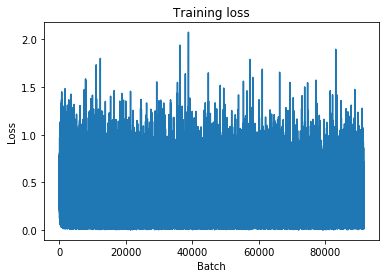

Loss на обучающей выборке: 0.23270


In [20]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

In [21]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in tqdm(test_dataloader):   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
#     print (label_ids.shape)
    batch_preds = np.argmax(logits, axis=1)
#     batch_labels = np.concatenate(label_ids)
    batch_labels = np.array(label_ids)

    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

100%|██████████| 1000/1000 [01:34<00:00, 10.64it/s]

Процент правильных предсказаний на валидационной выборке: 84.14%


In [26]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(valid_labels, valid_preds).ravel()

valid_labels = np.array(valid_labels)
print(np.array((tn, fp, fn, tp)) / valid_labels.shape[0],
      valid_labels.sum() / valid_labels.shape,
      (valid_labels.shape[0] - valid_labels.sum()) / valid_labels.shape)

n_toxic = valid_labels.sum()
n_non_toxic = valid_labels.shape[0] - valid_labels.sum()

print("Custom model")
print((tp / n_toxic).item() * 100, "% of toxic comments were predicted correctly")
print((fn / n_toxic).item() * 100, "% of toxic comments were marked non-toxic")
print((tn / n_non_toxic).item() * 100, "% of non-toxic comments were predicted correctly")
print((fp / n_non_toxic).item() * 100, "% of non-toxic comments were marked toxic")

[0.813875 0.032375 0.12625  0.0275  ] [0.15375] [0.84625]
Custom model
17.88617886178862 % of toxic comments were predicted correctly
82.11382113821138 % of toxic comments were marked non-toxic
96.17429837518465 % of non-toxic comments were predicted correctly
3.825701624815362 % of non-toxic comments were marked toxic


In [28]:
import sklearn
sklearn.metrics.roc_auc_score(valid_labels, valid_preds)

0.5703023861848664

In [ ]:
# for sentence in sentences:
#     sentence = sentence.replace('\"', '')
#     sentence = sentence.replace('\n', '')
#     sentence = sentence.lower()
    

In [ ]:
# sentences[5]

In [ ]:
# a = '"Some sentence"'

In [ ]:
# a.replace("\"", "")

In [ ]:
# def make_len(x):
#     return len(x.split())

# train_data_toxic_comment["len"] = train_data_toxic_comment["comment_text"].apply(make_len)
# train_data_toxic_comment["len"].describe()

In [ ]:
# train_data_toxic_comment.count() - no missing values
# train_data_toxic_comment.nunique() - no repeated comments
# train_data_toxic_comment['toxic'].value_counts() - imbalanced classes

In [ ]:
# train_data_unintended_bias = pd.read_csv("./Data/jigsaw-unintended-bias-train.csv")
# # train_data_unintended_bias.count() - there are missing values in columns which describe person from the comment

We have a lot of NaNs here, so I will replace them with something interesting. Some features are from 0 and 1, another are strictly categorical. We still have much more good comments than toxic ones - so again imbalanced classes.

In [ ]:
# # convert "approved" to 1 and "rejected" to 0
# train_data_unintended_bias["rating"] = train_data_unintended_bias["rating"].apply(lambda x: int(x == "approved"))

# # 8:32 - there are columns which describe person from the comment
# categorical_mean = train_data_unintended_bias.iloc[:, 8:32].mean()
# train_data_unintended_bias.iloc[:, 8:32] = train_data_unintended_bias.iloc[:, 8:32].fillna(categorical_mean)

# train_data_unintended_bias["len"] = train_data_unintended_bias["comment_text"].apply(make_len)
# train_data_unintended_bias["len"].describe()

In [ ]:
# train_data_unintended_bias.sample(5)